# Detecting Irregular Heartbeats using and Auto-Encoder with Pytorch

The purpose of this project is to build an autoencoder that will detect anomolous heartbeats. An autoencoder is a model that has two parts: an encoder and a decoder. The encoder part takes an input, and compresses the data down. The decoder part of the model takes the compressed data, and attempts to recreate the original input.

## What is the origin of this project?

I was inspired to do this project by the following tutorial: https://www.youtube.com/watch?v=qN3n0TM4Jno&t=2198s, which is where I obtained the dataset. I did this as part of a job application (which used auto-encoders combined with unsupervised learning on the hidden layer in order to group the incomming data). The youtube tutorial used LSTM networks, but I thought that dense networks should, theoretically, work, so I put it to the test. I also included a 'naive' non-machine learning approach, to show how good the autoencoder is as an alternatice.

## How do auto-encoders help to detect irregular heartbeats?

Heartbeats are captured using an electrocardigram as a time-series. In our dataset, the time series is broken down into 140 steps.

The autoencoder will accept a timeseries as an input (as a vector or lenth 140). It will then compress that data, by feeding through the encoder part of the model, and then decompress the data, by feeding it back through the decoder part. The output time series will then be compared to the input time series, and the loss calculated by looking at the different between outputted time series, and the original time series. In short, the model will learn to decompress an input vector of length 140, and then decompress back into a vector of length 140, and scored on how close the output and inputs are.

So, how does this help detect irregular heartbeats?

If the model works well, then if we feed it an input of a regular heartbeat, then it should return an output similar to the original. *However*, if we feed it an *irregular* heartbeat - one that it's never seen before - then it should be unable to reconstruct it. That is, the output will not look like the input.

## How can we use this to tell us which heartbeats are irregular?

Quite simply, we take each of the 140 points in the time series, and sum the square of the differences between the input and the output. If the model has successfully reconstructed the original timeseries, then it will have a low score. However, if the output has not successfully reconstructed the original timeseries, then it will have a high score.

By investigating the scores on unseen data, we can determine a sensible *threshold*. If the score is below the threshold, then we predict that the heartbeat is normal, but if the score is above the threshold, then we predict that the heartbeat is irregular.

## How will we measure success?
There are five types of heartbeat:
1. Normal
2. R-on-T premature ventricular contraction
3. Premature ventricular contraction
4. Supra-ventricular premative or ectopic beat
5. Unclassified beat

In order to judge the success of this model, I will first create a benchmark by applying a naive, non-machine learning method. We demand that any solution must have above 95% success rate on the normal heartbeats (since I'm not a subject matter expert, I can't comment on whether this is appropriate).

As another approach to measureing accuracy, I'll group all the non-normal heartbeats together into a single class, plot the precision-recall curves of the naive model and the machine learning model, and calculate the auc for the region where the recall is above 90% (because a recall lower than that isn't really worth considering).

# Data Analysis

In the first part of this investigation, we analyse the data. Our goals here are to:
1. See what the time series for regular and irrecgular heartbeats look like 
2. Investigate within-class variation (how different instances of a regular heatbeat varies)
3. Investigate between-class variation (how much variation is there between different types of heartbeat)

We're hoping for relatively small variation within-class, and relatively large amounts of variation between classes.

In [28]:
from scipy.io import arff
import pandas as pd

# import the data
data = arff.loadarff('data/ECG5000_TRAIN.arff')
train = pd.DataFrame(data[0])

data = arff.loadarff('data/ECG5000_TEST.arff')
test = pd.DataFrame(data[0])

train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


Each row represents a heartbeat, and each column is a timestep. The target (the final column), determines the kind of heartbeat.

Since we're building an autoencoder, we don't train our model on any of the irregular heartbeats, so we don't need the train/test split. Let's combine all the data together, and then split the regular heartbeats into train and test sets, and combine all of the different types of irregular heartbeats together.

In [29]:
# combine datasets
df = pd.concat([train,test], ignore_index=True)

# turn the 'target' column into an integer to make it easier to deal with
df.loc[:,['target']] = df.target.apply(lambda x: int(str(x)[2]))

print(df.shape)

(5000, 141)


So we have 5000 heartbeats in total. Let's find out how many of the different classes we have.

<BarContainer object of 5 artists>

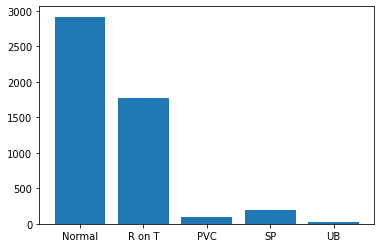

In [30]:
import matplotlib.pyplot as plt

heartbeat_types = [(df.target==i).sum() for i in range(1,6)]
heartbeat_names = ['Normal','R on T', 'PVC','SP','UB']

plt.bar(heartbeat_names,heartbeat_types)

There are clearly more normal heartbeats than irregular ones.

## Within- and between-class variation

Now let's take a look at the within and between class variation between heartbeats. To do this, we find the average and standard deviation of each timestep in the series. The mean will represent the 'average heartbeat'. We can use the standard deviation to give us an idea of the variation.

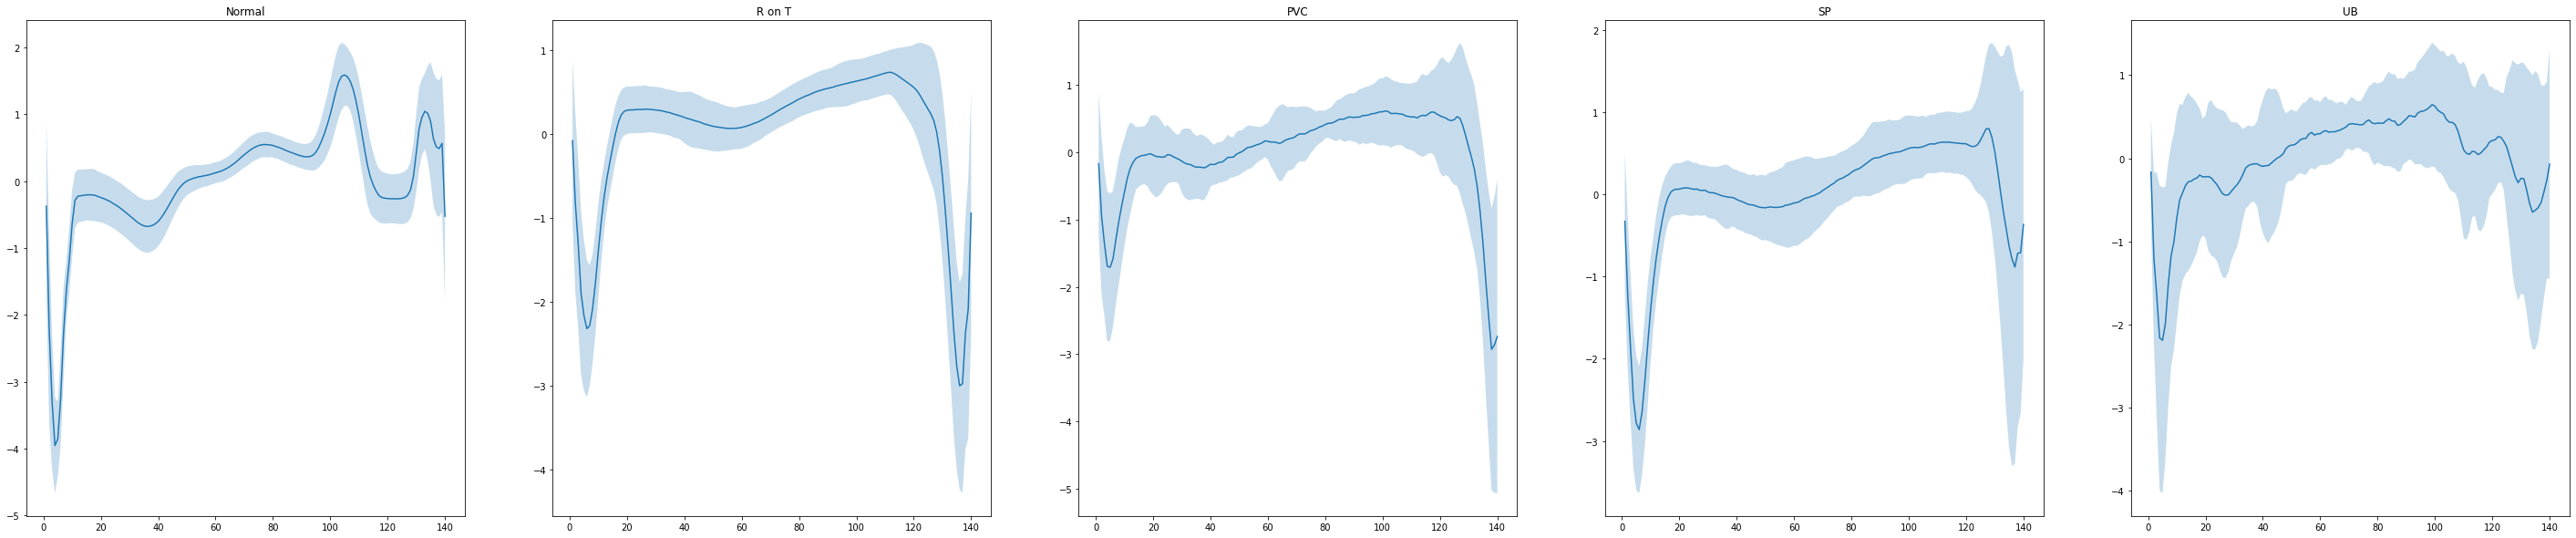

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50,10))

classes = ['Normal',' R on T', 'PVC', 'SP', 'UB']

# loop through each class
# determine the mean and standard deviation for each column
# plot the ouptut

for heart_type in range(1,6):
    mean = df[df.target == heart_type].drop(['target'],axis=1) \
                           .mean()
    std = df[df.target == heart_type].drop(['target'], axis=1) \
                        .std()
    
    ax = plt.subplot(1,5,heart_type)
    ax.set_title(classes[heart_type-1])
    ax = plt.plot(range(1,141),mean)
    ax = plt.fill_between(range(1,141),mean+std, mean-std,alpha = 0.25)

Some observations:
- The variation within the 'normal' class is relatively small.
- The variation between the 'normal' class, and all th other classes is relatively large
- The variation within the non-'normal' classes is different (though this fact is relatively unimportant)

This means that we can be hopeful that our autoencoder approach might work

# Preparting data for machine learning

Now that we've investigated the data, we need to prepare the data for the machine learning model.

First, let's split the 'normal' heartbeats into a training and a test set (we will later use the results from the test set to set a threshold to predict whether a heartbeat is normal or not).


In [32]:
import sklearn.model_selection

normal_df = df[df.target == 1].drop(['target'], axis=1)
seed = 42
train_df, test_df = sklearn.model_selection.train_test_split(
  normal_df,
  test_size=0.15,
  random_state=seed)

Now let's get the data into the right form for machine learning with pytorch.

In [33]:
import numpy as np
import torch

def prepare_data(df):
    '''
    Input: dataframe with 140 columns
    Output: dataframe in correct format
    '''
    data_list = df.astype(np.float32).to_numpy().tolist()
    dataset = torch.Tensor(data_list)
    return dataset


# let's run our two dataframes through the functions to get our train and test data
train = prepare_data(train_df)
test = prepare_data(test_df)

# Non-machine learning approach

Before we look at a machine-learning approach to this problem, let's first look at how effective a non-machine learning approach might be. The most basic approach is to employ the following strategy:
1. take a heartbeat you want to test
2. sum the squared differences between the average of the 'normal heartbeat' category. Call that the 'score'
3. set a threshold for the score, so hearbeats beneath that score are considered 'normal'

{'whiskers': [<matplotlib.lines.Line2D at 0x247540a1e20>,
 'caps': [<matplotlib.lines.Line2D at 0x247540b0460>,
 'boxes': [<matplotlib.lines.Line2D at 0x247540a1a90>,
 'medians': [<matplotlib.lines.Line2D at 0x247540b0b80>,
 'fliers': [<matplotlib.lines.Line2D at 0x247540b0f10>,
 'means': []}

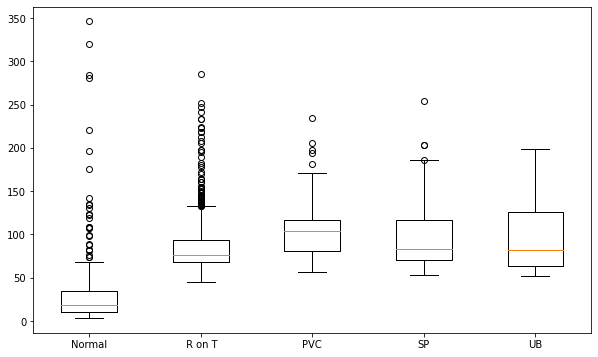

In [34]:
normal_mean = train_df.mean()

normal_scores = [sum((test_df.loc[row] - normal_mean)**2) for row in test_df.index]
rnt_scores = [sum((df[df.target == 2].drop(['target'], axis=1).loc[row] - mean)**2) for row in df[df.target == 2].index]
pvc_scores = [sum((df[df.target == 3].drop(['target'], axis=1).loc[row] - mean)**2) for row in df[df.target == 3].index]
p_scores = [sum((df[df.target == 4].drop(['target'], axis=1).loc[row] - mean)**2) for row in df[df.target == 4].index]
ub_scores = [sum((df[df.target == 5].drop(['target'], axis=1).loc[row] - mean)**2) for row in df[df.target == 5].index]

data_to_plot = [normal_scores,rnt_scores,pvc_scores,p_scores,ub_scores]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot,
                labels=classes) 

Let's suppose that we want to be able to detect a normal hearbeat not less than 95% of the time. Let's look at how 

In [35]:
thresh = 89

normal_success = round(len([i for i in data_to_plot[0] if i < thresh]) / len(data_to_plot[0]) * 100,2)
rnt_success = round(len([i for i in data_to_plot[1] if i > thresh]) / len(data_to_plot[1]) * 100,2)
pvc_success = round(len([i for i in data_to_plot[2] if i > thresh]) / len(data_to_plot[2]) * 100,2)
p_success = round(len([i for i in data_to_plot[3] if i > thresh]) / len(data_to_plot[3]) * 100,2)
ub_success = round(len([i for i in data_to_plot[4] if i > thresh]) / len(data_to_plot[4]) * 100,2)
print('normal success:',normal_success,'rnt success:',rnt_success,'pvc success:',pvc_success,'p success:',p_success,'ub success:',ub_success)

normal success: 95.21 rnt success: 28.98 pvc success: 66.67 p success: 43.3 ub success: 37.5


As we can see from these results, we aren't very good at guessing any of the non-normal heartbeat types!

### Precision-recall curve and AUC

If we group all of the non-normal heartbeats together into one 'abnormal' class, then we can investigate the efficacy of the model for different thresholds using a precision-recall curve.

We'll look at the area where precision is over 90%.

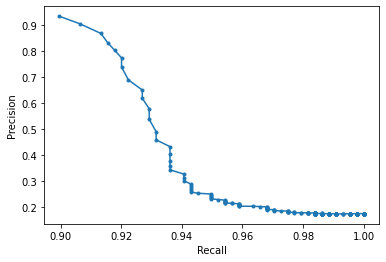

auc=  0.040659961328826474


In [37]:
from sklearn.metrics import auc


def precision_recall(thresh,data_to_plot):
    normal = data_to_plot[0]
    abnormal = data_to_plot[1] + data_to_plot[2] + data_to_plot[3] + data_to_plot[4]
    
    precision = sum(np.array(normal)<thresh) / (sum(np.array(normal)<thresh) + sum(np.array(abnormal)<thresh)+0.01)
    recall = sum(np.array(normal)<thresh) / len(normal)

    return precision, recall

precision = []
recall = []
for thresh in range(55,1000):
    pre,rec = precision_recall(thresh,data_to_plot)
    precision.append(pre)
    recall.append(rec) 

plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
# show the plot
plt.show()
print('auc= ',auc(recall,precision))

# Machine learning model: autoencoder

In this section, I build the machine learning model I'll use to help us improve this performance. The model I choose do to this is called an **autoencoder**, and the theory is described at the top of this notebook.

As a quick recap, an auto-encoder has two parts:
1. an encoder
2. a decoder
The encoder part of the model 'compresses' the original timeseries. The decoder part decompresses it back the original side. The model is scored on how well the output matches the input (so the model learns to reconstruct a timeseries).

In [38]:
from torch import nn, optim
import torch.nn.functional as F


class Encoder_FC(nn.Module):
  def __init__(self, size_of_hidden=10):
    super().__init__()
    self.size_of_hidden = size_of_hidden

    self.fc1 = nn.Linear(140,self.size_of_hidden)

  def forward(self,x):
    x = F.relu(self.fc1(x))

    return x

enc = Encoder_FC()

Now let's define a decoder part

In [39]:
class Decoder_FC(nn.Module):
  def __init__(self,size_of_hidden=10):
    super().__init__()
    self.size_of_hidden = size_of_hidden

    self.fc1 = nn.Linear(self.size_of_hidden,140)

  def forward(self,x):
    x = self.fc1(x)

    return x

dec = Decoder_FC(size_of_hidden=20)

Finally, let's define the complete autoencoder:

In [40]:
class Autoencoder(nn.Module):

  def __init__(self,size_of_hidden=10):
    super().__init__()
    self.size_of_hidden = size_of_hidden

    self.encoder = Encoder_FC(self.size_of_hidden)
    self.decoder = Decoder_FC(self.size_of_hidden)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

aut = Autoencoder()

In [41]:
import torch.optim as optim

def train_model(model,epochs):

  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  Epochs = epochs
  print(Epochs)

  for epoch in range(Epochs):
    for data in train:
      #data is a batch of featuresets and labels

      X = data
      Y = data
      
      #everytime we calculate loss, and optimize the model - we want to do this
      #why? This resets the gradient each time. We aren't sure why you wouldn't do this - possibly niche case
      optimizer.zero_grad()

      #output
      output = model(X.view(-1,140))
      

      #Different ways to calculate lost. We're using negative log loss.
      loss = F.smooth_l1_loss(output,Y.view(-1,140))
      
      #We have the loss function. We could now back-propagate.  
      loss.backward()
      
      #this adjusts the weights for us.
      optimizer.step()
    print(loss)

  return model

#train_model(aut)

## How good is it?

In [42]:
import matplotlib.pyplot as plt

def peek(image_number,model):
    '''
    input: number
    output: a plot of inputs and outputs for images indexed at that number
    '''

    fig = plt.figure(figsize=(25,5))

    classes = ['Normal',' R on T', 'PVC', 'SP', 'UB']

    # loop through each class
    # determine the mean and standard deviation for each column
    # plot the ouptut

    for i, heart_type in enumerate(classes):
        df_class = df[df.target == i+1].drop(['target'], axis=1)
        data = prepare_data(df_class)

        y = data[image_number]
        y_pred = model(y).detach().numpy()


        ax = plt.subplot(1,5,i+1)
        ax.set_title(classes[i])
        ax = plt.plot(range(1,141),y)
        ax = plt.plot(range(1,141),y_pred)

#peek(0,aut)

In [43]:
def test_model(model):


    data_to_plot = [[sum(line) for line in (test.detach().numpy() - model(test).detach().numpy())**2],
                    [sum(line) for line in (prepare_data(df[df.target == 2].drop(['target'], axis=1)).detach().numpy() - model(prepare_data(df[df.target == 2].drop(['target'], axis=1))).detach().numpy())**2],
                    [sum(line) for line in (prepare_data(df[df.target == 3].drop(['target'], axis=1)).detach().numpy() - model(prepare_data(df[df.target == 3].drop(['target'], axis=1))).detach().numpy())**2],
                    [sum(line) for line in (prepare_data(df[df.target == 4].drop(['target'], axis=1)).detach().numpy() - model(prepare_data(df[df.target == 4].drop(['target'], axis=1))).detach().numpy())**2],
                    [sum(line) for line in (prepare_data(df[df.target == 5].drop(['target'], axis=1)).detach().numpy() - model(prepare_data(df[df.target == 5].drop(['target'], axis=1))).detach().numpy())**2]
    ]
                    
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_to_plot,
                    labels=classes)               
    return data_to_plot
                    

5
tensor(0.0069, grad_fn=<SmoothL1LossBackward>)
tensor(0.0036, grad_fn=<SmoothL1LossBackward>)
tensor(0.0030, grad_fn=<SmoothL1LossBackward>)
tensor(0.0027, grad_fn=<SmoothL1LossBackward>)
tensor(0.0024, grad_fn=<SmoothL1LossBackward>)


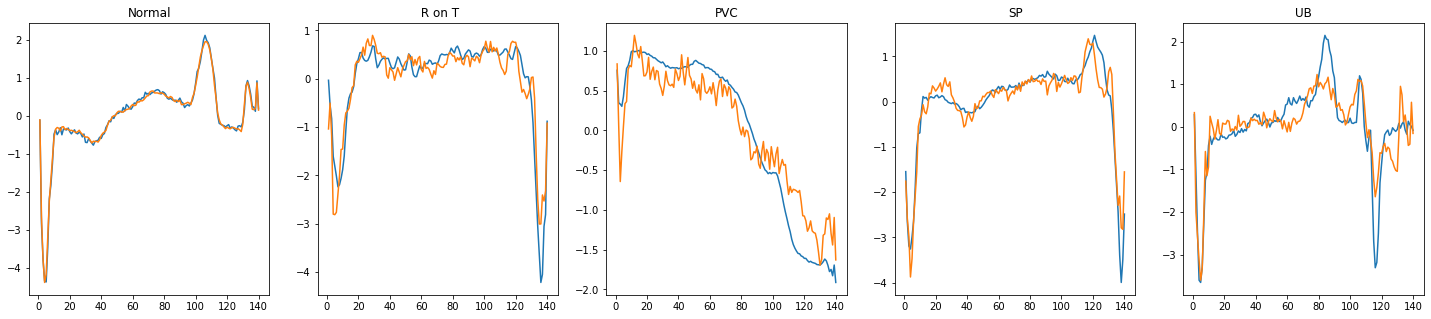

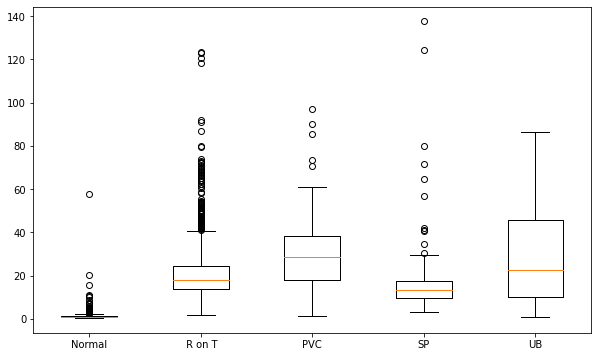

In [44]:
def end_to_end(size_of_hidden, epochs=10):
    aut = Autoencoder(size_of_hidden=size_of_hidden)
    model = train_model(aut,epochs)
    peek(0,model)
    scores = test_model(model)

    return scores
    
score = end_to_end(size_of_hidden=40, epochs = 5)

In [45]:
thresh = 4.1

normal_success = round(len([i for i in score[0] if i < thresh]) / len(score[0]) * 100,2)
rnt_success = round(len([i for i in score[1] if i > thresh]) / len(score[1]) * 100,2)
pvc_success = round(len([i for i in score[2] if i > thresh]) / len(score[2]) * 100,2)
p_success = round(len([i for i in score[3] if i > thresh]) / len(score[3]) * 100,2)
ub_success = round(len([i for i in score[4] if i > thresh]) / len(score[4]) * 100,2)
print('normal success:',normal_success,'rnt success:',rnt_success,'pvc success:',pvc_success,'p success:',p_success,'ub success:',ub_success)

normal success: 95.43 rnt success: 99.6 pvc success: 97.92 p success: 98.45 ub success: 87.5


# Precision-recall curve and AUC

Like we did for the naive model, let's plot a precision-recall curve and calculate the AUC (when precisions is greater than 90%).

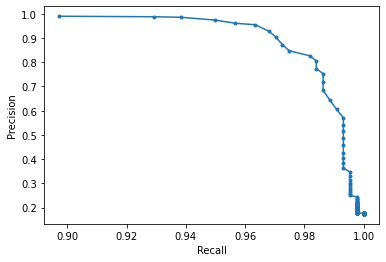

auc=  0.09077669968021958


In [55]:
precision = []
recall = []
for thresh in np.arange(2.25,200,0.5):
    pre,rec = precision_recall(thresh,score)
    precision.append(pre)
    recall.append(rec) 

plt.plot(recall, precision, marker='.')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
# show the plot
plt.show()
print('auc= ',auc(recall,precision))

# Cross-validation

To demonstrate that these results are robust, I perform a 10-fold cross-validation.

In [56]:

# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold
# data sample
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
# prepare cross validation
kfold = KFold(3)
# enumerate splits
for train, test in kfold.split(data):
	print('train: %s, test: %s' % (data[train], data[test]))

train: [0.3 0.4 0.5 0.6], test: [0.1 0.2]
train: [0.1 0.2 0.5 0.6], test: [0.3 0.4]
train: [0.1 0.2 0.3 0.4], test: [0.5 0.6]


In [63]:
kfold = KFold(10)
folds = kfold.split(df[df.target == 1].drop(['target'],axis=1))

In [79]:
for train, test in folds:
    #train_data = df[df.target == 1].drop(['target'],axis=1).iloc([train])
    #aut = Autoencoder(size_of_hidden=40)
    #model = train_model(aut,3)
    break
print(len(train))
print(len(test))
df[df.target == 1].drop(['target'],axis=1).loc[]

2628
291


KeyError: '[292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499] not in index'

In [80]:
train

array([   0,    1,    2, ..., 2625, 2626, 2627])

# Conclusion

As you can see, using the autoencoder produces a far higher success rate for all of the non-normal heartbeats, for a 95% success rate for normal heartbeats.

We can also see that the auc is over twice as high for the auto-encoder than for the naive model, going from 0.04 to 0.084 (over the appropriate range).

# Discussion

Overall, I'm pleased with the results of this model. I demonstrated that, by using an auto-encoder to encode and then decode my time-series, I was able to significantly improve on a more basic model that didn't use machine learning.

Were I to continue this model, the next thing I'd do is implmenent the machine learning model using LSTMs, like the tutor who inspired this work did. I'd be interested to know whether and to what degree an LSTM network could improve the results. For readers unsure about LSTM, they're a type of network that can be used in ordered data (such as a time series), where the output for each node is fed along to the next, effectively allowing the network to know the previous time step (and learn whether that is important).